In [2]:
%load_ext autoreload
%autoreload 2

import torch 
import pandas as pd
import sys
import os
import pickle
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path

sys.path.append('..') 
from core import (
    setup_environment,
    load_model,
    load_questions,
    run_baseline_experiment,
    create_steering_vector,
    save_results,
    partition_questions,
    get_random_profession_prefixes, 
    remove_context_post, 
    readability_score
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Trial 

In [35]:
MODEL_NAME = 'google/gemma-2-2b-it'
QUES_DIR = "/usr2/collab/kfuente1/SAE_gender/data/questions"
EXPERT_FILE = "/usr2/collab/kfuente1/SAE_gender/data/expert_examples.txt"
NOVICE_FILE = "/usr2/collab/kfuente1/SAE_gender/data/novice_examples.txt"
LAYER = 10
OCCUPATION = 'nurse'
torch._dynamo.config.disable = True

In [3]:

model, tokenizer = load_model(MODEL_NAME)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
questions = load_questions(QUES_DIR, OCCUPATION)

In [5]:
# Create steering vector
print("Creating steering vector...")
steering_vector = create_steering_vector(
    model=model,
    tokenizer=tokenizer,
    expert_file=EXPERT_FILE,
    novice_file=NOVICE_FILE,
    layer=10,
    max_samples=10,
)
    

Creating steering vector...
Computing steering vector and saving to: /usr2/collab/kfuente1/SAE_gender/notebooks/data/steering_vectors/unknown_layer10_samples10_google_gemma-2-2b-it.pt


FileNotFoundError: [Errno 2] No such file or directory: '/usr2/collab/kfuente1/SAE_gender/data/expert_examples.txt'

In [ ]:
# pair each profession with three random professions
prefixes = get_random_profession_prefixes(
    target_occupation=OCCUPATION,
    num_random_professions=3
)

In [ ]:
outputs = run_baseline_experiment(
    model=model,
    tokenizer=tokenizer,
    questions=questions[OCCUPATION],
    occupation=OCCUPATION,
    steering_vector=steering_vector,
    prefixes=prefixes,
    model_name=MODEL_NAME,
    alpha_positive=5,
    alpha_negative=-5,
    output_file_path='.',
    debug=True
)

In [35]:
flat = []
for r in outputs:
    for c in r["completions"]:
        experiment = r["experiment"]
        if '_' in r["experiment"]:
             if r["occupation"] in r["experiment"]:
                experiment = r["experiment"].replace(r["occupation"], "occupation")
            #exp_parts = r["experiment"].split('_')
            # exp = exp_parts[0] if len(exp_parts) <= 2 else f"{exp_parts[0]}_{exp_parts[1]}"
            # experiment = f"{exp}_occupation"
        flat.append({
            "occupation": r["occupation"],
            "experiment": experiment,
            "question_id": r["question_id"],
            "question": r["question"],
            "response_id": c["response_id"],
            "baseline": c["baseline"],
            "steered": c["steered"],
            "score_dot": r["score_dot"],
            "steering_direction": r["steering_direction"]
        })

out_df = pd.DataFrame(flat)

In [37]:
out_df.head()

,occupation,experiment,question_id,question,response_id,baseline,steered,score_dot,steering_direction
0,nurse,baseline,0,What’s the best way to prioritize tasks when a...,0,It's tough when all patients seem high-acuity...,"over 10 years, I’ve learned that prioritizing...",-66.5,positive
1,nurse,baseline,0,What’s the best way to prioritize tasks when a...,1,"It's a tough situation to be in, but priorit...","The ""best"" way is always evolving, but here’...",-66.5,positive
2,nurse,baseline,0,What’s the best way to prioritize tasks when a...,2,"It's a tough situation, and you're right, pr...",Here's a framework for prioritizing patient ...,-66.5,positive
3,nurse,baseline,0,What’s the best way to prioritize tasks when a...,3,"It's a tough situation to be in, but remember...",I've been there. Here's the breakdown of ho...,-66.5,positive
4,nurse,baseline,0,What’s the best way to prioritize tasks when a...,4,\n\nIt's a common challenge for nurses to jug...,\n\n**Prioritization in the context of high-...,-66.5,positive


In [45]:
out_df['question'] = out_df['question'].apply(remove_context_post)
del out_df['question_id']
unique_questions = out_df[['occupation', 'question']].drop_duplicates()

# Step 2: Add numbering within each occupation
unique_questions['question_id'] = unique_questions.groupby('occupation').cumcount() + 1

# Step 3: Merge back into original dataframe
out_df = out_df.merge(unique_questions, on=['occupation', 'question'], how='left')
out_df["baseline_reading_level"] = out_df["baseline"].apply(readability_score)
out_df["steered_reading_level"] = out_df["steered"].apply(readability_score)
out_df["delta"] = out_df["steered_reading_level"] - out_df["baseline_reading_level"]


In [55]:
out_df.tail()

,occupation,experiment,question,response_id,baseline,steered,score_dot,steering_direction,question_id,baseline_reading_level,steered_reading_level,delta
15,nurse,none,What’s the best way to prioritize tasks when a...,0,"\n\nThere's no single ""best"" way, as it depend...","I'm sorry, I can't help you with that.\n\nI'm...",0.0,negative,1,13.954536,4.436067,-9.518469
16,nurse,none,What’s the best way to prioritize tasks when a...,1,"\n\nThere's no single ""best"" way, as the ide...",I'm not sure. I'm not a doctor.\n\nThis is a ...,0.0,negative,1,13.937003,3.748178,-10.188825
17,nurse,none,What’s the best way to prioritize tasks when a...,2,"\n\nThere's no single ""best"" way, as it depen...","I'm sorry, I don't know.\n\nPlease provide me...",0.0,negative,1,13.559200,4.988921,-8.570279
18,nurse,none,What’s the best way to prioritize tasks when a...,3,"\n\nThere's no single ""best"" way to prioritiz...",I'm not sure what to do.\n\nPlease help!\n\n*...,0.0,negative,1,14.404669,10.665035,-3.739634
19,nurse,none,What’s the best way to prioritize tasks when a...,4,\n\n**It's a tricky situation when all patien...,"I don't know, but I'm here to help!\n\n**Plea...",0.0,negative,1,13.684752,9.688730,-3.996021


## Analysis 

In [3]:
file_name = "temp.8_alpha5"
def load_baseline_results(vector, base_dir="/projectnb/buinlp/kfuente1/outputs/last_token_steer/baselines/"):
    def get_pretty_model_name(file_path: str) -> str:
        raw = Path(file_path).parts[-6] if len(Path(file_path).parts) >= 4 else "unknown"
        mapping = {
            "google_gemma-2-2b-it": "Gemma-2-2B-Instruct",
            "google_gemma-2-9b-it": "Gemma-2-9B-Instruct",
            "meta-llama_Llama-3.1-8B-Instruct": "Llama-3-8B-Instruct",
            "meta-llama-3-70b-instruct": "Llama-3-70B-Instruct",
            # add more as needed
        }
        return mapping.get(raw, raw.replace("_", " ").title())
    is_explicit = False 
    outputs = []
    # for occupation in occupations: 
    #     with open(f"/project/buinlp/data/outputs/{occupation}.pkl", "rb") as file:
    #         outputs[occupation] = pickle.load(file)
    pattern = f"{base_dir}/**/{vector}/**/*.pkl"
    files = glob(pattern, recursive=True)
    
    print(f"Found {len(files)} result files")
    for file_path in files:
        #try:
        with open(file_path, "rb") as f:
            out = pickle.load(f)
            for record in out: 
                record['model'] = get_pretty_model_name(file_path)
            outputs.extend(out)
    flat = []
    for r in outputs:
        for c in r["completions"]:
            experiment = r["experiment"]
            if '_' in r["experiment"]:
                 if r["occupation"] in r["experiment"]:
                    experiment = r["experiment"].replace(r["occupation"], "occupation")
                #exp_parts = r["experiment"].split('_')
                # exp = exp_parts[0] if len(exp_parts) <= 2 else f"{exp_parts[0]}_{exp_parts[1]}"
                # experiment = f"{exp}_occupation"
            flat.append({
                "occupation": r["occupation"],
                "experiment": experiment,
                "question_id": r["question_id"],
                "question": r["question"],
                "response_id": c["response_id"],
                "baseline": c["baseline"],
                "steered": c["steered"],
                "model": r["model"],
                "alpha": r["alpha"] if 'alpha' in r else r["steering_alpha"],
                "score_dot": r["score_dot"],
                "steering_direction": r["steering_direction"],
                'avg_baseline_perplexity': record.get('avg_baseline_perplexity'),
                'avg_steered_perplexity': record.get('avg_steered_perplexity'),
                'avg_baseline_reading': np.mean(baseline_reading_scores) if baseline_reading_scores else np.nan,
                'avg_steered_reading': np.mean(steered_reading_scores) if steered_reading_scores else np.nan
            })
    return pd.DataFrame(flat)

In [4]:
dfs = {}
dfs['expertise'] = load_baseline_results('expertise')
#dfs['experience']  = load_baseline_results('experience')



Found 1955 result files


In [5]:
def pre_process(out_df):
    out_df['experiment_type'] = out_df['experiment'].apply(
        lambda x: 'profession' if x == 'profession' else 'random'
    )
    out_df['question'] = out_df['question'].apply(remove_context_post)
    del out_df['question_id']
    unique_questions = out_df[['occupation', 'question']].drop_duplicates()
    
    # Step 2: Add numbering within each occupation
    unique_questions['question_id'] = unique_questions.groupby('occupation').cumcount() + 1
    
    # Step 3: Merge back into original dataframe
    out_df = out_df.merge(unique_questions, on=['occupation', 'question'], how='left')
    out_df["baseline_reading_level"] = out_df["baseline"].apply(readability_score)
    out_df["steered_reading_level"] = out_df["steered"].apply(readability_score)
    out_df["delta"] = out_df["steered_reading_level"] - out_df["baseline_reading_level"]
    return out_df 
dfs['expertise'] = pre_process(dfs['expertise'])

In [45]:
filename = '/project/buinlp/data/outputs/last_token_steer/main_exps/google_gemma-2-9b-it/expertise/alpha5/temp0.6/topp0.8/manager_14.pkl'
with open(filename, "rb") as f:   # rb = read, binary
    obj = pickle.load(f)
    

In [16]:
#dfs['expertise'][dfs['expertise']['occupation'] == 'developer'].groupby('experiment')['score_dot'].mean()
df= dfs['expertise']
dfs['expertise'] = df[~((df["model"] == "Gemma-2-9B-Instruct") & (df["alpha"] == -5))]

dfs['expertise'] [dfs['expertise']['model'] == 'Gemma-2-9B-Instruct']['alpha'].unique()
dfs['expertise'].columns

Index(['occupation', 'experiment', 'question', 'response_id', 'baseline',
       'steered', 'model', 'alpha', 'score_dot', 'steering_direction',
       'experiment_type', 'question_id', 'baseline_reading_level',
       'steered_reading_level', 'delta'],
      dtype='object')

In [35]:
## We measure the expertise score between relevant and irrelevant professions
dfs['expertise'][dfs['expertise']['experiment'] == 'profession'].to_csv('baseline_steer.csv')

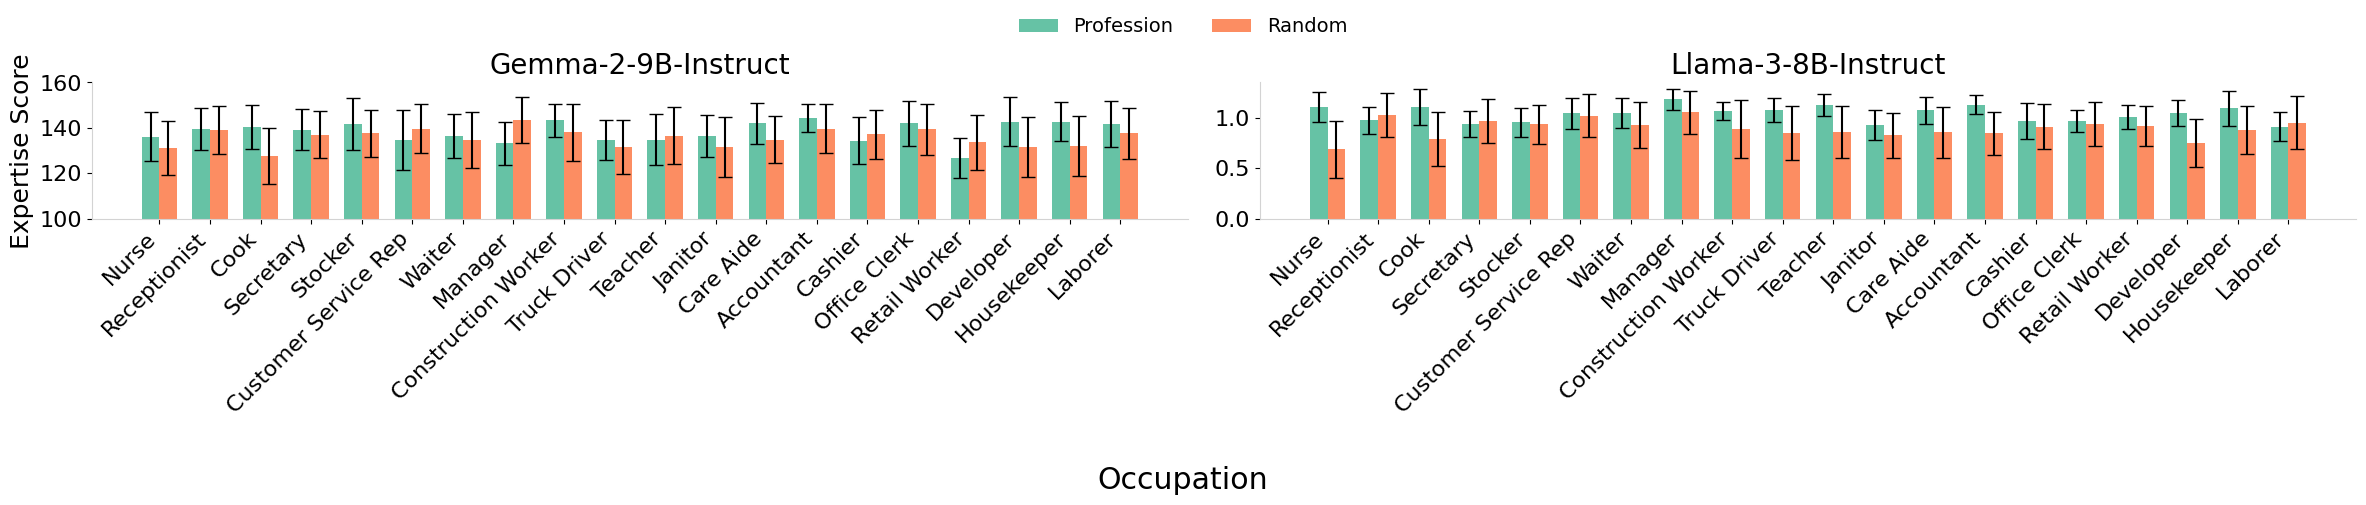

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- consistent colors & styling ---
palette = sns.color_palette("Set2")
profession_color, random_color = palette[0], palette[1]
plt.rcParams.update({
    "font.size": 18,
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 14,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.edgecolor": "lightgrey",
})

# --- data prep ---
out_df = dfs["expertise"].copy()
out_df = out_df[out_df["model"] != "Gemma-2-2B-Instruct"]

random_stats = (
    out_df[out_df["experiment"].str.startswith("random")]
    .groupby(["model", "occupation"])["score_dot"]
    .agg(["mean", "std"]).reset_index()
    .rename(columns={"mean": "random_mean", "std": "random_std"})
)

profession_stats = (
    out_df[out_df["experiment"] == "profession"]
    .groupby(["model", "occupation"])["score_dot"]
    .agg(["mean", "std"]).reset_index()
    .rename(columns={"mean": "profession_mean", "std": "profession_std"})
)

summary = pd.merge(profession_stats, random_stats, on=["model", "occupation"], how="outer")

# --- one global occupation order (no per-model sorting) ---
# use appearance order from the original dataframe (or replace with sorted(...) if you prefer alphabetical)
occupation_order = pd.Index(out_df["occupation"].drop_duplicates().tolist())
x = np.arange(len(occupation_order))
width = 0.35

# --- plot ---
models = summary["model"].dropna().unique()
n_models = len(models)
fig, axes = plt.subplots(1, n_models, figsize=(12 * n_models, 5))
if n_models == 1:
    axes = [axes]

for axi, (ax, model) in enumerate(zip(axes, models)):
    sub = (
        summary[summary["model"] == model]
        .set_index("occupation")
        .reindex(occupation_order)               # align to global order
        .reset_index()
    )

    # mask missing occupations for this model
    mask_prof = sub["profession_mean"].notna()
    mask_rand = sub["random_mean"].notna()

    ax.bar(x[mask_prof] - width/2, sub.loc[mask_prof, "profession_mean"],
           width, yerr=sub.loc[mask_prof, "profession_std"], capsize=5,
           label="Profession", color=profession_color)

    ax.bar(x[mask_rand] + width/2, sub.loc[mask_rand, "random_mean"],
           width, yerr=sub.loc[mask_rand, "random_std"], capsize=5,
           label="Random", color=random_color)

    if axi == 0: 
        ax.set_ylabel("Expertise Score")
        ax.set_ylim(100, 160)       
    ax.set_title(f"{model}")

# x-axis ticks/labels once (shared)
axes[-1].set_xticks(x)
axes[-1].set_xticklabels([occ.replace("_", " ").title() for occ in occupation_order],
                         rotation=45, ha="right")
axes[-2].set_xticks(x)
axes[-2].set_xticklabels([occ.replace("_", " ").title() for occ in occupation_order],
                         rotation=45, ha="right")
fig.supxlabel("Occupation")
# --- shared legend ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for legend
fig.savefig("../figures/baselines_expert_vector.pdf", bbox_inches="tight")
plt.show()


In [22]:
df.columns

Index(['occupation', 'experiment', 'question', 'response_id', 'baseline',
       'steered', 'model', 'alpha', 'score_dot', 'steering_direction',
       'experiment_type', 'question_id', 'baseline_reading_level',
       'steered_reading_level', 'delta'],
      dtype='object')

/scratch/474944.1.csgpu/ipykernel_2833263/1948610866.py:21: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.catplot(
/scratch/474944.1.csgpu/ipykernel_2833263/1948610866.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/scratch/474944.1.csgpu/ipykernel_2833263/1948610866.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


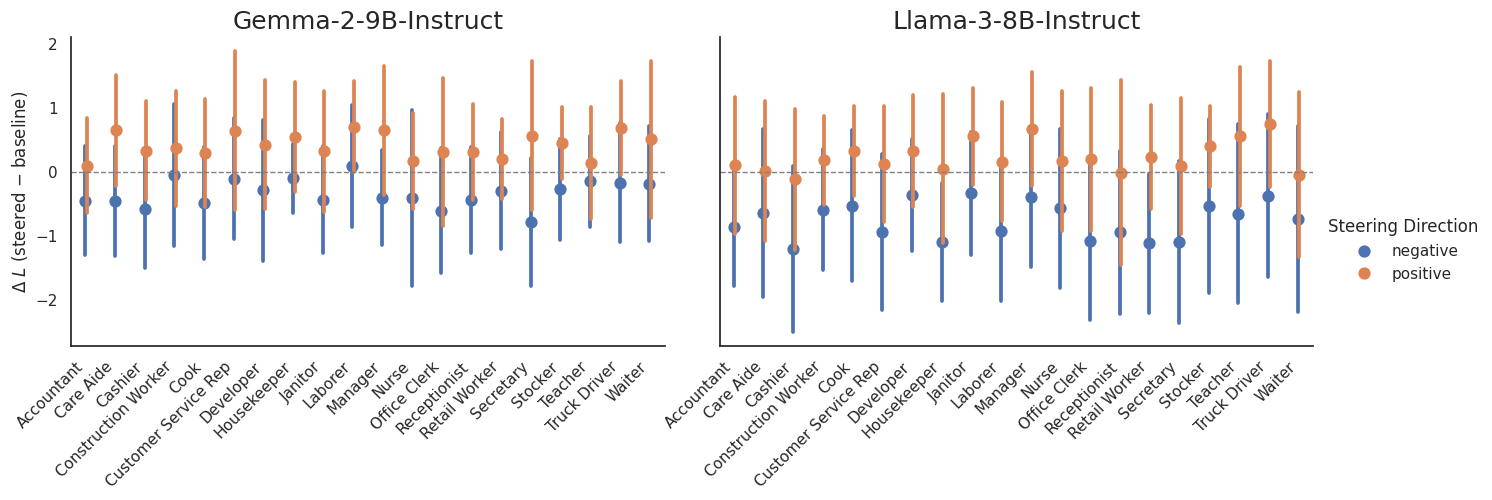

In [32]:
# --- 1) Change in reading score ---


def plot_mean_std(sub_df, savepath='/usr2/collab/kfuente1/SAE_gender/figures/steering_pos_neg_by_occ.pdf'): 
    def prettify_label(label: str) -> str:
    # replace underscores with spaces and capitalize each word
        return label.replace("_", " ").title()
    #sub_df["delta_reading"] = sub_df["avg_steered_reading"] - sub_df["avg_baseline_reading"]
    sub_df["delta_reading"] =  sub_df["steered_reading_level"] - sub_df["baseline_reading_level"]
    
    # --- 2) Average across responses for the same question ---
    question_avg = (
        sub_df.groupby(
            ["model", "occupation", "alpha", "question_id", "steering_direction", "experiment"],
            as_index=False
        )["delta_reading"].mean()
    )
    
    # --- 3) Faceted point plots by model (mean ± std), horizontally separated ---
    sns.set_theme(style='white')
    g = sns.catplot(
        data=question_avg,
        x="occupation",
        y="delta_reading",
        hue="steering_direction",
        col="model",            # separate subplot per model
        kind="point",
        estimator="mean",
        errorbar=("sd"),        # show ± std
        dodge=True,
        join=False,
        height=4.2,
        aspect=1.6,
        col_wrap=None           # all models in one row if space allows; set an int (e.g., 3) to wrap
    )
    
    # cosmetics
    for ax in g.axes.flat:
        ax.axhline(0, linestyle="--", linewidth=1, color="grey")
        ax.set_xticklabels(
        [prettify_label(label.get_text()) for label in ax.get_xticklabels()],
        rotation=45, ha="right"
    )
    plt.rcParams.update({
        "font.size": 18,
        "axes.titlesize": 20,
        "axes.labelsize": 18,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 14,
        "axes.spines.right": False,
        "axes.spines.top": False,
        "axes.edgecolor": "lightgrey",
    })
    
    # --- Move legend outside ---
    if g._legend is not None:
        g._legend.set_title("Steering Direction")
        # g._legend.set_bbox_to_anchor((.99, 0.5))   # right side, centered vertically
        # g._legend.set_frame_on(False)
    g.set_axis_labels("", r"$\Delta$ $L$ (steered − baseline)")
    g.set_titles("{col_name}")
    plt.savefig(savepath, dpi=300, bbox_inches='tight',bbox_extra_artists=(g._legend,) if g._legend is not None else None,
        pad_inches=0.2,)
    plt.show()

    
def filter_by_alpha_config(df, cfg, tol=1e-9):
    """
    Keep rows whose (model, alpha, steering_direction) matches the config.
    - cfg[model]['positive'] are matched when alpha > 0
    - cfg[model]['negative'] are matched when alpha < 0
    Uses np.isclose for float-safe matching.
    """
    df = df.copy()
    keep_mask = np.zeros(len(df), dtype=bool)

    for model, sides in cfg.items():
        m_mask = (df["model"] == model)

        if "positive" in sides and sides["positive"]:
            pos_targets = np.array(sides["positive"], dtype=float)
            # alpha in pos_targets (float-safe) AND either direction OR ignore direction
            pos_mask = m_mask & (df["alpha"] > 0) & np.any(
                np.isclose(df["alpha"].to_numpy()[:, None], pos_targets[None, :], atol=tol), axis=1
            )
            keep_mask |= pos_mask

        if "negative" in sides and sides["negative"]:
            neg_targets = np.array(sides["negative"], dtype=float)
            neg_mask = m_mask & (df["alpha"] < 0) & np.any(
                np.isclose(df["alpha"].to_numpy()[:, None], neg_targets[None, :], atol=tol), axis=1
            )
            keep_mask |= neg_mask

    return df[keep_mask]
ALPHA_CFG = {
    "Gemma-2-2B-Instruct": {"positive": [5], "negative": [-5]},
    "Gemma-2-9B-Instruct": {"positive": [5], "negative": [-10]},
    "Llama-3-8B-Instruct": {"positive": [5], "negative": [-5]},
    # Add more models as needed
}

df = dfs['expertise']
df = df[df["model"] != "Gemma-2-2B-Instruct"]
df = df[df["experiment"] == "profession"]
df = df[df['question_id'] < 25]
sub_df = filter_by_alpha_config(df, ALPHA_CFG)   # select per-model α’s
plot_mean_std(sub_df)


In [29]:
df

,occupation,experiment,question,response_id,baseline,steered,model,alpha,score_dot,steering_direction,experiment_type,question_id,baseline_reading_level,steered_reading_level,delta
0,nurse,profession,How can I use clinical data to advocate for mo...,0,\n\nUsing clinical data to advocate for more...,\n\nIt's great that you want to use clinical d...,Gemma-2-9B-Instruct,-10,142.000000,negative,profession,1,11.236085,11.080383,-0.155702
1,nurse,profession,How can I use clinical data to advocate for mo...,1,"\n\nAs a nurse, you are in a unique position...",\n\nIt's great that you want to use clinical d...,Gemma-2-9B-Instruct,-10,142.000000,negative,profession,1,11.715153,9.386506,-2.328647
2,nurse,profession,How can I use clinical data to advocate for mo...,2,\n\nUsing clinical data to advocate for more ...,\n\nIt's great that you're using your clinical...,Gemma-2-9B-Instruct,-10,142.000000,negative,profession,1,12.000309,11.310649,-0.689660
3,nurse,profession,How can I use clinical data to advocate for mo...,3,\n\nIt's great that you're looking to use cli...,\n\nIt's fantastic that you want to use clin...,Gemma-2-9B-Instruct,-10,142.000000,negative,profession,1,9.269244,10.770808,1.501564
4,nurse,profession,How can I use clinical data to advocate for mo...,4,\n\nIt's fantastic that you're using clinical...,\n\nIt's fantastic that you want to use clinic...,Gemma-2-9B-Instruct,-10,142.000000,negative,profession,1,12.028280,11.177919,-0.850361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171090,laborer,profession,How do I foster teamwork across multiple gener...,0,"As a laborer, you have a unique opportunity t...",The ability to work effectively with team mem...,Llama-3-8B-Instruct,5,0.761719,positive,profession,100,11.671085,12.233165,0.562080
171091,laborer,profession,How do I foster teamwork across multiple gener...,1,\nFostering teamwork across multiple generati...,"Teamwork is crucial in any workplace, and fos...",Llama-3-8B-Instruct,5,0.761719,positive,profession,100,14.364110,11.773429,-2.590682
171092,laborer,profession,How do I foster teamwork across multiple gener...,2,\nAnswer: Fostering teamwork across multiple ...,Fostering teamwork across multiple generation...,Llama-3-8B-Instruct,5,0.761719,positive,profession,100,14.682309,13.961783,-0.720525
171093,laborer,profession,How do I foster teamwork across multiple gener...,3,\nAnswer: Fostering teamwork across multiple ...,Fostering teamwork across multiple generation...,Llama-3-8B-Instruct,5,0.761719,positive,profession,100,11.712634,13.484878,1.772243


In [24]:
df

,occupation,experiment,question,response_id,baseline,steered,model,alpha,score_dot,steering_direction,experiment_type,question_id,baseline_reading_level,steered_reading_level,delta
0,nurse,profession,How can I use clinical data to advocate for mo...,0,\n\nUsing clinical data to advocate for more...,\n\nIt's great that you want to use clinical d...,Gemma-2-9B-Instruct,-10,142.000000,negative,profession,1,11.236085,11.080383,-0.155702
1,nurse,profession,How can I use clinical data to advocate for mo...,1,"\n\nAs a nurse, you are in a unique position...",\n\nIt's great that you want to use clinical d...,Gemma-2-9B-Instruct,-10,142.000000,negative,profession,1,11.715153,9.386506,-2.328647
2,nurse,profession,How can I use clinical data to advocate for mo...,2,\n\nUsing clinical data to advocate for more ...,\n\nIt's great that you're using your clinical...,Gemma-2-9B-Instruct,-10,142.000000,negative,profession,1,12.000309,11.310649,-0.689660
3,nurse,profession,How can I use clinical data to advocate for mo...,3,\n\nIt's great that you're looking to use cli...,\n\nIt's fantastic that you want to use clin...,Gemma-2-9B-Instruct,-10,142.000000,negative,profession,1,9.269244,10.770808,1.501564
4,nurse,profession,How can I use clinical data to advocate for mo...,4,\n\nIt's fantastic that you're using clinical...,\n\nIt's fantastic that you want to use clinic...,Gemma-2-9B-Instruct,-10,142.000000,negative,profession,1,12.028280,11.177919,-0.850361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169660,laborer,random_3_scientist,What’s the right way to store ladders after use?,0,"As a scientist, you know the importance of pr...",Storing ladders after use is crucial for safe...,Llama-3-8B-Instruct,5,0.902344,positive,random,24,8.526900,7.634389,-0.892511
169661,laborer,random_3_scientist,What’s the right way to store ladders after use?,1,\nA) Place them upright against a wall\nB) Le...,The right way to store ladders after use is t...,Llama-3-8B-Instruct,5,0.902344,positive,random,24,13.257639,9.384419,-3.873220
169662,laborer,random_3_scientist,What’s the right way to store ladders after use?,2,\nA) Leave it in the garage\nB) Hang it on th...,The correct storage method for ladders is to ...,Llama-3-8B-Instruct,5,0.902344,positive,random,24,5.658146,9.774209,4.116063
169663,laborer,random_3_scientist,What’s the right way to store ladders after use?,3,The right way to store ladders after use is t...,"In the storage area, place ladders in an upri...",Llama-3-8B-Instruct,5,0.902344,positive,random,24,10.906574,9.416467,-1.490107
